## Loading

In [2]:
%load_ext autoreload
%autoreload 2

import model as m
import data_processing as dp
import feature_engineering as fe
import make_plots as mp
import parameters as p
import evaluation as e

import optuna
import pandas as pd
import numpy as np
import warnings
from datetime import datetime,date
from datetime import timedelta


import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
warnings.filterwarnings("ignore")

default_max_rows = pd.get_option('display.max_rows')

c:\Users\Howard\anaconda3\envs\CZ_torch39\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Data Preprocessing

In [3]:
data_original = pd.read_csv("data/data_with_alpha_and_beta.csv")

### NAs in dataset

Number of columns before filtering: 367


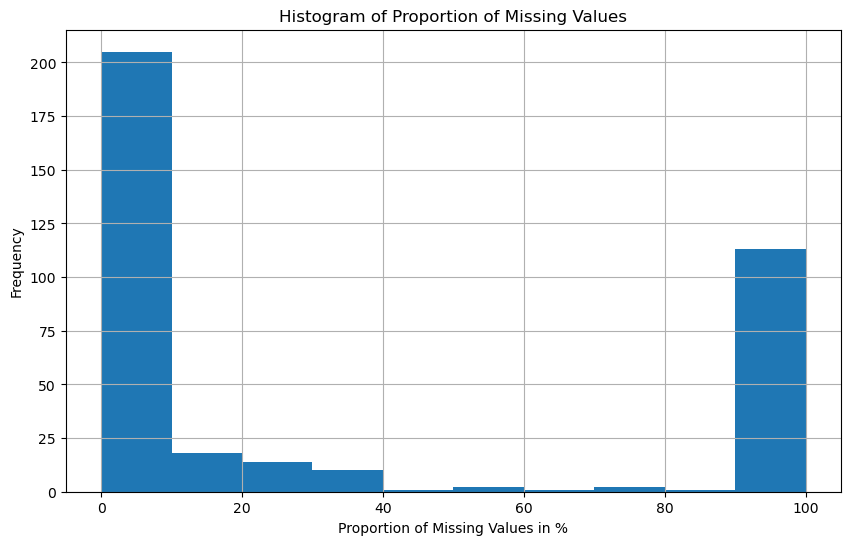

Number of columns after filtering: 202


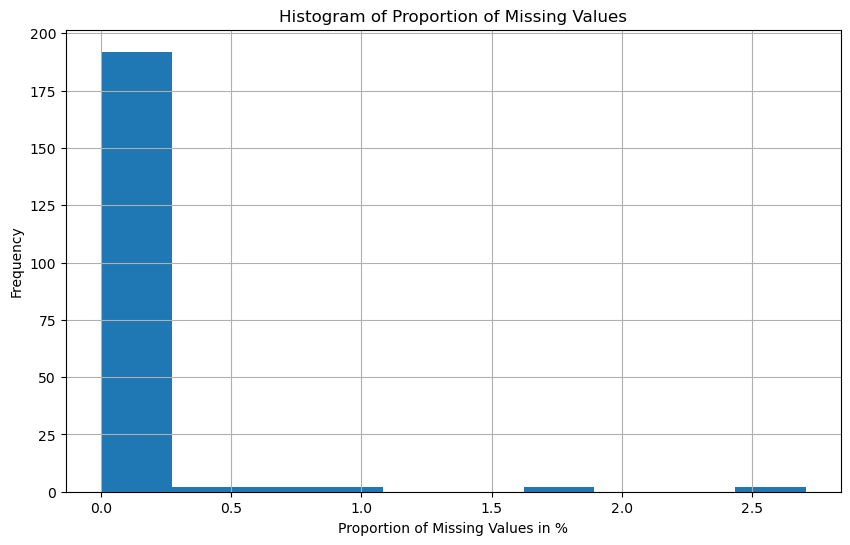

In [4]:
data = dp.data_loading(data_original)
print("="*120)
print("Number of columns before filtering:", data.shape[1])
mp.plot_missing_values(data)

data_filtered = dp.feature_filter(data)

print("="*120)
print("Number of columns after filtering:", data_filtered.shape[1])
mp.plot_missing_values(data_filtered)

## Imputation

## Baseline MOdel

In [46]:
data_imputed = dp.fillnas_and_convert(data, dataOffset="Y")
X_train, y_train, X_val, y_val, X_test, y_test = m.split_train_val_test(data_imputed)
input_dim=X_train.shape[1]

In [118]:
model_classes = [
    m.OLSModel(),
    # m.OLS3Model(),
    m.PLSModel(),
    m.LASSOModel(),
    m.ElasticNetModel(),
    # m.GBRTModel(),
    # m.RFModel(),
    m.XGBoostModel()
]

num_layers_range = range(1, 6)
for num_layers in num_layers_range:
    model_classes.append(m.NNModel(input_dim=input_dim, num_layers=num_layers))

model_r_2 = {}
models_fitted = {}
model_res = {}
for model_class in tqdm(model_classes, desc="Training Models"):
    model_name = model_class.name if hasattr(model_class, "name") else model_class.__class__.__name__
    print(model_name)
    model_fitted, scaler = m.train(X_train, y_train, model_class)
    validation_res = m.validation(X_val, y_val, model_fitted, scaler)
    r_2 = e.calculate_r2_oos(validation_res['y'], validation_res['y_pred'])


    models_fitted[model_name] = model_fitted
    model_res[model_name] = validation_res
    model_r_2[model_name] = r_2

for model_name, r_2 in model_r_2.items():
    print(f"{model_name}: {r_2}")

Training Models:  40%|████      | 4/10 [00:00<00:00, 36.70it/s]

OLSModel
PLSModel
LASSOModel
ElasticNetModel
XGBoostModel
NNModel_nn1
NNModel_nn2
NNModel_nn3


Training Models:  80%|████████  | 8/10 [00:00<00:00, 12.56it/s]

NNModel_nn4
NNModel_nn5


Training Models: 100%|██████████| 10/10 [00:00<00:00, 12.35it/s]

OLSModel: -33.45661608846877
PLSModel: -0.532979578584043
LASSOModel: 0.6124369854927272
ElasticNetModel: 0.6124369854927272
XGBoostModel: 0.09173819621717927
NNModel_nn1: 0.06123783145703099
NNModel_nn2: -0.04998484728722086
NNModel_nn3: 0.5455201240220521
NNModel_nn4: 0.4207866682413832
NNModel_nn5: 0.5502250921704137


## Hyperparameter tuning

In [28]:
for model_class in model_classes:
    model_name = model_class.name if hasattr(model_class, "name") else model_class.__class__.__name__
    print(model_name)

OLSModel
PLSModel
LASSOModel
ElasticNetModel
XGBoostModel
NNModel_nn1
NNModel_nn2
NNModel_nn3
NNModel_nn4
NNModel_nn5


In [124]:
models_to_tune = [
    m.OLSModel,
    m.OLS3Model,
    m.PLSModel,
    m.LASSOModel,
    m.ElasticNetModel,
    m.GBRTModel,
    m.RFModel,
    m.XGBoostModel
]
best_trials = e.hyperparameter_tuning(X_train, y_train, X_val, y_val, models_to_tune, n_trials=3)

Tuning Models:   0%|          | 0/1 [00:00<?, ?it/s][I 2024-03-18 09:51:02,015] A new study created in memory with name: no-name-20807512-0f49-4cd5-81e4-accc4d7ee244
[I 2024-03-18 09:51:02,060] Trial 0 finished with value: -30.50158702884221 and parameters: {'epsilon': 1.3197592628513748, 'alpha': 0.00016007777406174895}. Best is trial 0 with value: -30.50158702884221.
[I 2024-03-18 09:51:02,104] Trial 1 finished with value: -27.766433106071258 and parameters: {'epsilon': 1.2672730909253258, 'alpha': 0.008100839407380375}. Best is trial 1 with value: -27.766433106071258.
[I 2024-03-18 09:51:02,147] Trial 2 finished with value: -68.27606477720661 and parameters: {'epsilon': 1.9700078780797425, 'alpha': 0.0013374025898056743}. Best is trial 1 with value: -27.766433106071258.
Tuning Models: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

Tunning OLSModel
Best trial for OLSModel: {'epsilon': 1.2672730909253258, 'alpha': 0.008100839407380375}


## Feature Importance

In [146]:
features = X_train.columns[:20]  
importance_df, percentage_change_df = e.reduction_in_r2(model_classes, X_train, y_train, features=features, permutation_importance=False)

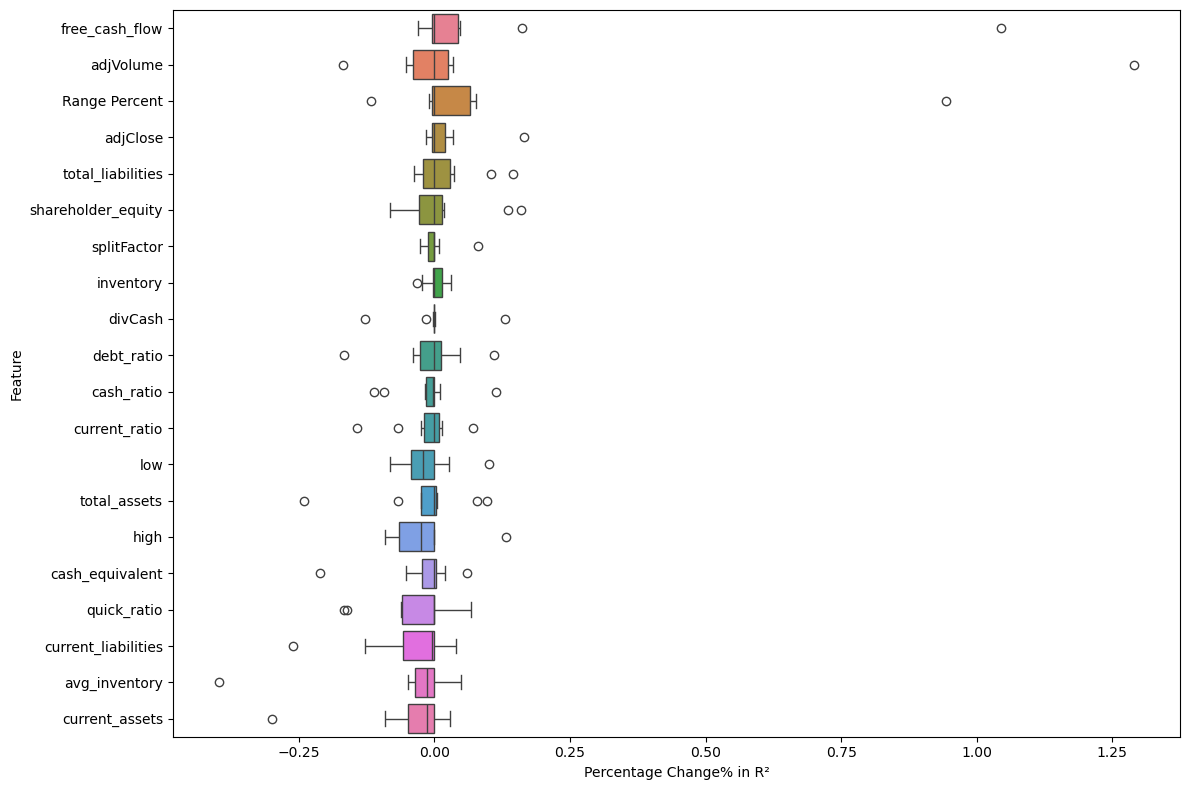

In [144]:
mp.macroeconomic_feature_importance(percentage_change_df)
mp.characteristic_feature_importance(importance_df)

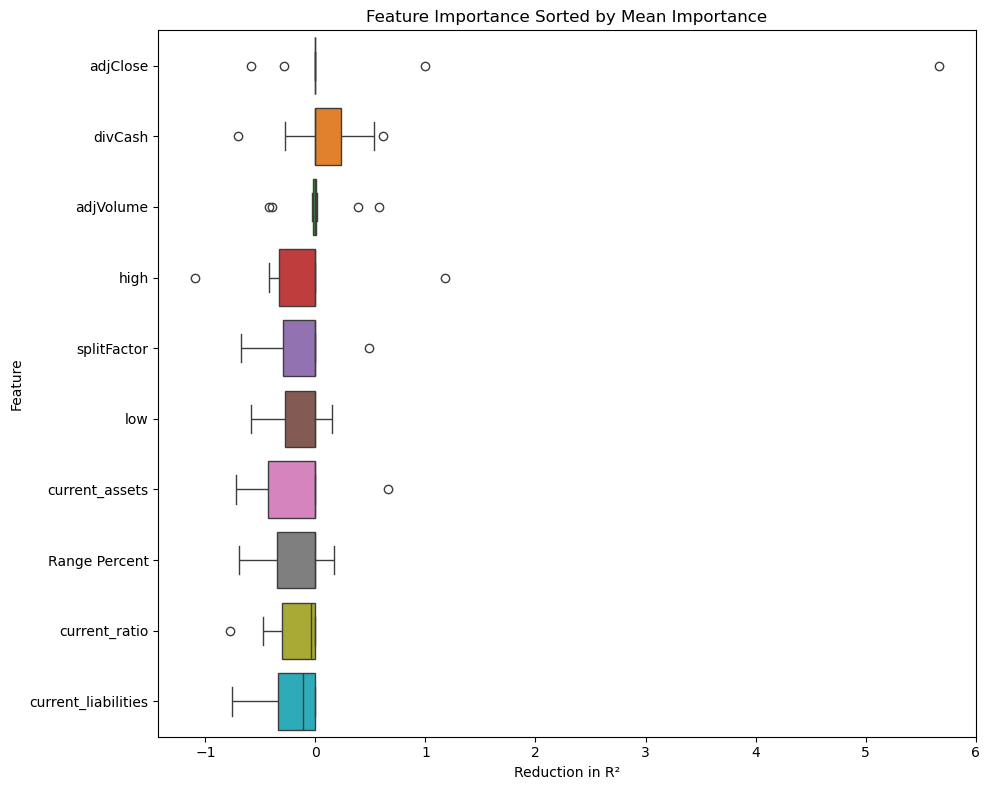

In [131]:
mean_importance = reduction_df.mean(axis=1)
sorted_features = mean_importance.sort_values(ascending=False).index
plt.figure(figsize=(10, 8))
sns.boxplot(data=reduction_df.loc[sorted_features].T, orient='h')
plt.title('Feature Importance Sorted by Mean Importance')
plt.xlabel('Reduction in R²')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()